In [ ]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats
from scipy import ndimage # HCSR metric
from sklearn.model_selection import train_test_split

import random
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

import itertools
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Increasing resolution with GANs

In [ ]:
# combining resized original and augmented images
low_freq_combined = low_freq_images + augmented_low_freq
high_freq_combined = high_freq_images + augmented_high_freq

# splitting
low_freq_train, low_freq_test, high_freq_train, high_freq_test = train_test_split(low_freq_combined, high_freq_combined, test_size=0.40, random_state=42)

print("Low frequency train:", len(low_freq_train))
print("Low frequency test:", len(low_freq_test))
print("High frequency train:", len(high_freq_train))
print("High frequency test:", len(high_freq_test))


Low frequency train: 1200
Low frequency test: 800
High frequency train: 1200
High frequency test: 800


In [ ]:
# data loading and preprocessing
class UltrasoundDataset(Dataset):
  def __init__(self, low_freq_images, high_freq_images, transform=None):
    self.low_freq_images = low_freq_images
    self.high_freq_images = high_freq_images
    self.transform = transform

  def __len__(self):
    return max(len(self.low_freq_images), len(self.high_freq_images))

  def __getitem__(self, idx):
    low_img = self.low_freq_images[idx % len(self.low_freq_images)]
    high_img = self.high_freq_images[idx % len(self.high_freq_images)]

    # convert numpy arrays to PIL images
    low_img = Image.fromarray(low_img)
    high_img = Image.fromarray(high_img)

    if self.transform:
      low_img = self.transform(low_img)
      high_img = self.transform(high_img)

    return low_img, high_img

# define the generator model
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # Initial convolution block
    self.main = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False),
      nn.InstanceNorm2d(64),
      nn.ReLU(True),

      # Downsampling layers
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.InstanceNorm2d(128),
      nn.ReLU(True),
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
      nn.InstanceNorm2d(256),
      nn.ReLU(True),

      # Residual blocks
      *[ResidualBlock(256) for _ in range(6)],

      # Upsampling layers
      nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
      nn.InstanceNorm2d(128),
      nn.ReLU(True),
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
      nn.InstanceNorm2d(64),
      nn.ReLU(True),

      # Output layer
      nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
      nn.Tanh()
    )

  def forward(self, x):
    return self.main(x)

# define a residual block for the generator
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(channels),
      nn.ReLU(True),
      nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(channels)
    )

  def forward(self, x):
      return x + self.block(x)  # skip connection

# define the discriminator model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # Convolutional layers for PatchGAN discriminator
    self.main = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
      nn.InstanceNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
      nn.InstanceNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
      nn.InstanceNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False)
    )

  def forward(self, x):
    return self.main(x)

In [ ]:
# Initialize the model

# transformers
transform = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])

# load dataset
dataset = UltrasoundDataset(low_freq_train, high_freq_train, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# transfer to GPU
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# training

for epoch in range(10): # 10 epochs
  start_time = time.time()

  for i, (real_A, real_B) in enumerate(dataloader):
    real_A = real_A.to(device)
    real_B = real_B.to(device)

    # Train generators
    optimizer_G.zero_grad()

    # Identity loss
    same_B = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B, real_B)
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A, real_A)

    # GAN loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    loss_GAN_B2A = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_A = criterion_cycle(recovered_A, real_A)
    recovered_B = netG_A2B(fake_A)
    loss_cycle_B = criterion_cycle(recovered_B, real_B)

    # Total loss
    loss_G = loss_GAN_A2B + loss_GAN_B2A + 10 * (loss_cycle_A + loss_cycle_B) + 5 * (loss_identity_A + loss_identity_B)
    loss_G.backward()
    optimizer_G.step()

    # Train discriminators
    # D_A
    optimizer_D_A.zero_grad()
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
    loss_D_A = (loss_D_real + loss_D_fake) * 0.5
    loss_D_A.backward()
    optimizer_D_A.step()

    # D_B
    optimizer_D_B.zero_grad()
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
    loss_D_B = (loss_D_real + loss_D_fake) * 0.5
    loss_D_B.backward()
    optimizer_D_B.step()

  print(f"Epoch {epoch+1}/{epochs} completed in {time.time() - start_time:.2f}s")

Epoch 1/10 completed in 451.65s
Epoch 2/10 completed in 452.67s
Epoch 3/10 completed in 451.65s
Epoch 4/10 completed in 452.07s
Epoch 5/10 completed in 452.30s
Epoch 6/10 completed in 452.17s
Epoch 7/10 completed in 452.31s
Epoch 8/10 completed in 452.58s
Epoch 9/10 completed in 452.85s
Epoch 10/10 completed in 452.94s


In [ ]:
# save trained models

save_path_G_A2B = '/content/drive/MyDrive/netG_A2B.pth'
save_path_G_B2A = '/content/drive/MyDrive/netG_B2A.pth'
save_path_D_A = '/content/drive/MyDrive/netD_A.pth'
save_path_D_B = '/content/drive/MyDrive/netD_B.pth'

torch.save(netG_A2B.state_dict(), save_path_G_A2B)
torch.save(netG_B2A.state_dict(), save_path_G_B2A)
torch.save(netD_A.state_dict(), save_path_D_A)
torch.save(netD_B.state_dict(), save_path_D_B)

In [ ]:
# evaluate

def calculate_cnr(real, fake):
  real_mean = np.mean(real)
  fake_mean = np.mean(fake)
  noise = np.std(real - fake)
  cnr = abs(real_mean - fake_mean) / (noise + 1e-6)
  return cnr

def calculate_hcsr(real, fake):
  high_intensity_real = real[real > np.percentile(real, 90)]
  high_intensity_fake = fake[fake > np.percentile(fake, 90)]
  signal = np.mean(real)
  hcsr = abs(np.mean(high_intensity_real) - np.mean(high_intensity_fake)) / (signal + 1e-6)
  return hcsr

def evaluate(real, fake):
  real_img = real.squeeze(0).cpu().detach().numpy()
  fake_img = fake.squeeze(0).cpu().detach().numpy()
  cnr_value = calculate_cnr(real_img, fake_img)
  hcsr_value = calculate_hcsr(real_img, fake_img)
  return cnr_value, hcsr_value

cnr_values_difference, hcsr_values_difference = [], []

for real_A, real_B in dataloader:
  real_A = real_A.to(device)
  fake_B = netG_A2B(real_A)

  cnr_value_difference, hcsr_value_difference = evaluate(real_A, fake_B)

  cnr_values_difference.append(cnr_value_difference)
  hcsr_values_difference.append(hcsr_value_difference)

avg_cnr_difference = np.mean(cnr_values_difference)
avg_hcsr_difference = np.mean(hcsr_values_difference)

print(f"Average the difference of CNR (real_mean - fake_mean): {avg_cnr_difference:.4f}")
print(f"Average the difference of HCSR (real_mean - fake_mean): {avg_hcsr_difference:.4f}")

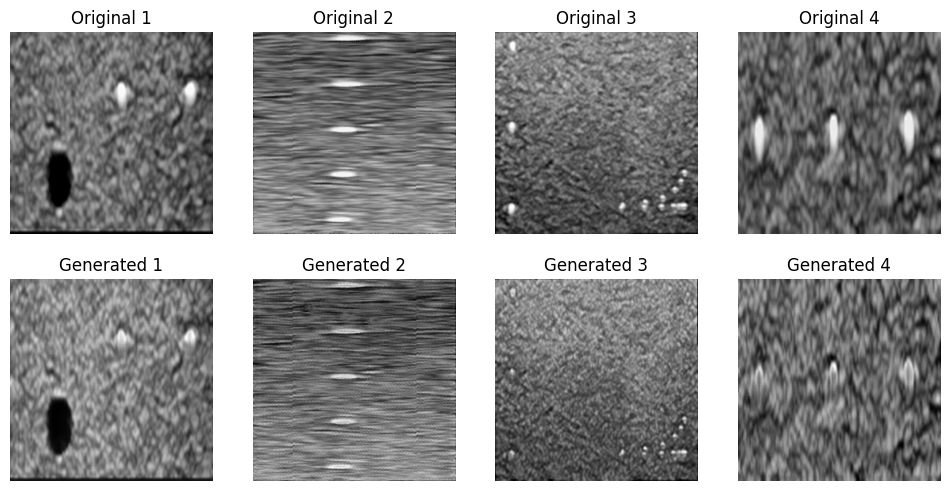

In [ ]:
# plot

def tensor_to_image(tensor):
  tensor = tensor.squeeze(0).cpu().detach().numpy()
  if tensor.ndim == 3:
    tensor = tensor.squeeze(0)
  tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
  return tensor

def plot_real_vs_fake(real_images, fake_images, num_images=4):
  fig, axes = plt.subplots(2, num_images, figsize=(12, 6))

  for i in range(num_images):
    real_img = tensor_to_image(real_images[i])
    fake_img = tensor_to_image(fake_images[i])

    axes[0, i].imshow(real_img, cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(fake_img, cmap='gray')
    axes[1, i].set_title(f'Generated {i+1}')
    axes[1, i].axis('off')

  plt.subplots_adjust(wspace=0.2, hspace=0.15)
  plt.show()

real_images, fake_images = [], []

for real_A, real_B in dataloader2:
  real_A = real_A.to(device)
  fake_B = netG_A2B(real_A)

  real_images.append(real_A)
  fake_images.append(fake_B)

  if len(real_images) >= 4:
    break

plot_real_vs_fake(real_images, fake_images, num_images=4)